In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd

import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical


%matplotlib inline

/home/dmitriy/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/titanic_train.csv', index_col = 'PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data=data.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [8]:
# Пишем наши собственные препроцессоры
# Обратите внивание тут добавлено несколько новых препроцессоров (в сравнение с 4 работой)

class FillNa(TransformerMixin, BaseEstimator):
    """
    Удаление пропусков в данных
    """
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем пропуски в данных
        """
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        
    
    
class DropOutlet(TransformerMixin, BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания 
        случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
    
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """
    
    def __init__(self, axis):
        self.axis = axis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)
        

In [6]:
data.iloc[:,1:8].isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [9]:
# Создадим наш pipeline
# drop_outlet, to_matrix, norm - это просто названия препроцессоров данное пользователем
# выбираем данные для обучающей выборки (то что будет подано на вход алгоритмам машинного обучения)
X_data = data.iloc[:,1:8].copy()
# Кодируем все классы в виде единичных векторов
X_data = pd.get_dummies(X_data)

# выбираем данные для обучающей выборки (то что будет на выходу алгоритмов машинного обучения)
Y_data = data[data.columns[0]].copy()

# Создаем препроцессор для заполнения пропусков
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

# Убираем вылеты из данных
pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)

# Соглачуем два массива X и Y
# Записи которые были удалены из массива X должны быть удалены и из массива Y
# Для удаления записей мы берем индексы из массива X и оставляем записи в массиве Y с индексами, которые есть в X
outletless_data_Y = Y_data[ fill_na_pipe.fit_transform(Y_data).index.isin(outletless_data_X.index) ]

# Нормализуем данные X
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

# Нормализуем данные Y
pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False))
])

# вызываем препроцессоры
number_data_ready_X = pipe_x.fit_transform(outletless_data_X)
number_data_ready_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_ready_X.shape, number_data_ready_Y.shape)

(751, 10) (751, 2)


In [10]:
number_data_ready_X[:10,:], number_data_ready_Y[::40]

(array([[1.        , 0.37002318, 0.33333333, 0.        , 0.04397492,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [0.        , 0.5638622 , 0.33333333, 0.        , 0.4323693 ,
         1.        , 0.        , 1.        , 0.        , 0.        ],
        [1.        , 0.41848293, 0.        , 0.        , 0.04806914,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.52751738, 0.33333333, 0.        , 0.32207838,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [1.        , 0.52751738, 0.        , 0.        , 0.04882733,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [0.        , 0.75770122, 0.        , 0.        , 0.31457232,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [1.        , 0.1277244 , 1.        , 0.5       , 0.12783054,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [1.        , 0.4305

In [11]:
import sys
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

In [12]:
X_train = number_data_ready_X
Y_train = number_data_ready_Y
X_train.shape, Y_train.shape

((751, 10), (751, 2))

In [13]:
model = Sequential()
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1]))
model.add(Dense(Y_train.shape[1], activation=activations.softmax))
model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])


In [14]:
model.fit(X_train, Y_train, verbose=2, epochs=100, batch_size=3)

Epoch 1/100
 - 3s - loss: 0.6135 - categorical_accuracy: 0.6897
Epoch 2/100
 - 1s - loss: 0.4850 - categorical_accuracy: 0.7949
Epoch 3/100
 - 1s - loss: 0.4607 - categorical_accuracy: 0.7883
Epoch 4/100
 - 1s - loss: 0.4532 - categorical_accuracy: 0.7989
Epoch 5/100
 - 1s - loss: 0.4490 - categorical_accuracy: 0.7843
Epoch 6/100
 - 1s - loss: 0.4455 - categorical_accuracy: 0.7816
Epoch 7/100
 - 1s - loss: 0.4435 - categorical_accuracy: 0.7923
Epoch 8/100
 - 1s - loss: 0.4403 - categorical_accuracy: 0.7989
Epoch 9/100
 - 1s - loss: 0.4376 - categorical_accuracy: 0.7843
Epoch 10/100
 - 1s - loss: 0.4352 - categorical_accuracy: 0.7989
Epoch 11/100
 - 1s - loss: 0.4335 - categorical_accuracy: 0.8016
Epoch 12/100
 - 3s - loss: 0.4341 - categorical_accuracy: 0.7963
Epoch 13/100
 - 1s - loss: 0.4330 - categorical_accuracy: 0.7976
Epoch 14/100
 - 1s - loss: 0.4303 - categorical_accuracy: 0.7976
Epoch 15/100
 - 1s - loss: 0.4290 - categorical_accuracy: 0.7989
Epoch 16/100
 - 1s - loss: 0.4265 

In [15]:
model.evaluate(X_train, Y_train)

751/751 [==============================] - 0s 510us/step


[0.3933091951353096, 0.8282290282008175]

In [16]:
from keras import callbacks

In [17]:
#перемешиваем выборку для репрезентативности
XY_data = np.hstack( (number_data_ready_X, number_data_ready_Y) ).transpose((0,1))
np.random.shuffle(XY_data)
# Делим выборки
point_split = round(XY_data.shape[0] * 0.8)
train_data = XY_data[:point_split]
test_data = XY_data[point_split:]
#Выводим информацию 
print("Всего данных: {Z}".format(Z=XY_data.shape[0]))
print("Тренировочных данных: {Z}".format(Z=train_data.shape[0]))
print("Тестовых данных: {Z}".format(Z=test_data.shape[0]))
# Делим все на входные и выходные данные
# Тренировочные
X_train = train_data[:, :number_data_ready_X.shape[1] ]
Y_train = train_data[:, :number_data_ready_Y.shape[1] ]
print("Размер данные для тренировки (входных): {Z}".format(Z=X_train.shape))
print("Размер данные для тренировки (выходных): {Z}".format(Z=Y_train.shape))

# Тестовые
X_test = test_data[:, :number_data_ready_X.shape[1] ]
Y_test = test_data[:, :number_data_ready_Y.shape[1] ]
print('Размер данные для теста (входных): {Z}'.format(Z=X_test.shape))
print('Размер данные для теста (выходных): {Z}'.format(Z=Y_test.shape))

Всего данных: 751
Тренировочных данных: 601
Тестовых данных: 150
Размер данные для тренировки (входных): (601, 10)
Размер данные для тренировки (выходных): (601, 2)
Размер данные для теста (входных): (150, 10)
Размер данные для теста (выходных): (150, 2)


In [18]:
#обертка для работы keras 2 и более раз 
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model

In [19]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(),
    ]    
)

Начинаем обучение сети
Train on 601 samples, validate on 150 samples
Epoch 1/100
601/601 [==============================] - 5s 8ms/step - loss: 0.7645 - categorical_accuracy: 0.6905 - val_loss: 0.7183 - val_categorical_accuracy: 0.6400
Epoch 2/100
601/601 [==============================] - 2s 4ms/step - loss: 0.7062 - categorical_accuracy: 0.8136 - val_loss: 0.6587 - val_categorical_accuracy: 0.8400
Epoch 3/100
601/601 [==============================] - 2s 4ms/step - loss: 0.6652 - categorical_accuracy: 0.9168 - val_loss: 0.6090 - val_categorical_accuracy: 0.9067
Epoch 4/100
601/601 [==============================] - 2s 4ms/step - loss: 0.6329 - categorical_accuracy: 0.9085 - val_loss: 0.5843 - val_categorical_accuracy: 0.8600
Epoch 5/100
601/601 [==============================] - 2s 4ms/step - loss: 0.6198 - categorical_accuracy: 0.8935 - val_loss: 0.5762 - val_categorical_accuracy: 0.8600
Epoch 6/100
601/601 [==============================] - 2s 4ms/step - loss: 0.6151 - categorical_

601/601 [==============================] - 3s 5ms/step - loss: 0.6097 - categorical_accuracy: 0.9052 - val_loss: 0.5700 - val_categorical_accuracy: 0.8667
Epoch 50/100
601/601 [==============================] - 2s 3ms/step - loss: 0.6098 - categorical_accuracy: 0.9068 - val_loss: 0.5699 - val_categorical_accuracy: 0.8600
Epoch 51/100
601/601 [==============================] - 2s 3ms/step - loss: 0.6099 - categorical_accuracy: 0.9002 - val_loss: 0.5690 - val_categorical_accuracy: 0.8867
Epoch 52/100
601/601 [==============================] - 2s 3ms/step - loss: 0.6101 - categorical_accuracy: 0.9068 - val_loss: 0.5700 - val_categorical_accuracy: 0.8600
Epoch 53/100
601/601 [==============================] - 2s 3ms/step - loss: 0.6098 - categorical_accuracy: 0.9068 - val_loss: 0.5693 - val_categorical_accuracy: 0.8733
Epoch 54/100
601/601 [==============================] - 2s 3ms/step - loss: 0.6096 - categorical_accuracy: 0.9002 - val_loss: 0.5687 - val_categorical_accuracy: 0.8867
Epoch

Epoch 98/100
601/601 [==============================] - 3s 5ms/step - loss: 0.6086 - categorical_accuracy: 0.9052 - val_loss: 0.5677 - val_categorical_accuracy: 0.8800
Epoch 99/100
601/601 [==============================] - 3s 4ms/step - loss: 0.6085 - categorical_accuracy: 0.9085 - val_loss: 0.5677 - val_categorical_accuracy: 0.8800
Epoch 100/100
601/601 [==============================] - 2s 3ms/step - loss: 0.6085 - categorical_accuracy: 0.9135 - val_loss: 0.5678 - val_categorical_accuracy: 0.8800


In [20]:
model.evaluate(X_train, Y_train)

601/601 [==============================] - 0s 215us/step


[0.6081532997616912, 0.9034941770669426]

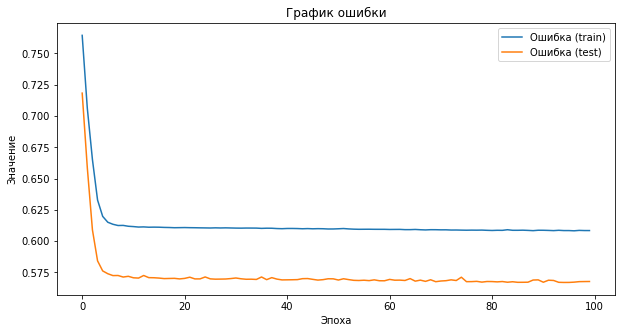

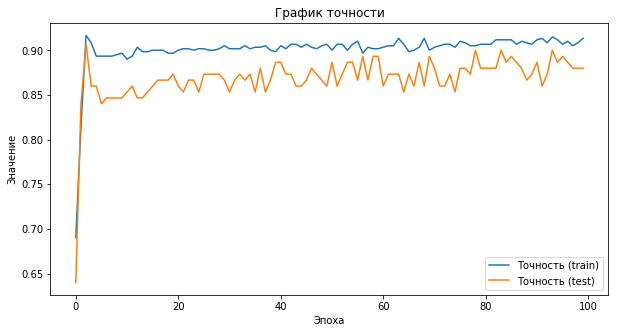

In [21]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [22]:
#Повтор, но с разделением данных в keras
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
    epochs=100,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 600 samples, validate on 151 samples
Epoch 1/100
600/600 [==============================] - 5s 9ms/step - loss: 0.8271 - categorical_accuracy: 0.3517 - val_loss: 0.6591 - val_categorical_accuracy: 0.6358
Epoch 2/100
600/600 [==============================] - 2s 4ms/step - loss: 0.5959 - categorical_accuracy: 0.7050 - val_loss: 0.5162 - val_categorical_accuracy: 0.7881
Epoch 3/100
600/600 [==============================] - 2s 4ms/step - loss: 0.5161 - categorical_accuracy: 0.7717 - val_loss: 0.4660 - val_categorical_accuracy: 0.8079
Epoch 4/100
600/600 [==============================] - 2s 4ms/step - loss: 0.4882 - categorical_accuracy: 0.7883 - val_loss: 0.4442 - val_categorical_accuracy: 0.8212
Epoch 5/100
600/600 [==============================] - 2s 4ms/step - loss: 0.4832 - categorical_accuracy: 0.7800 - val_loss: 0.4334 - val_categorical_accuracy: 0.8146
Epoch 6/100
600/600 [==============================] - 2s 4ms/step - loss: 0.4780 - categorical_

600/600 [==============================] - 3s 5ms/step - loss: 0.4408 - categorical_accuracy: 0.7967 - val_loss: 0.3768 - val_categorical_accuracy: 0.8278
Epoch 50/100
600/600 [==============================] - 3s 4ms/step - loss: 0.4390 - categorical_accuracy: 0.7950 - val_loss: 0.3781 - val_categorical_accuracy: 0.8278
Epoch 51/100
600/600 [==============================] - 2s 4ms/step - loss: 0.4395 - categorical_accuracy: 0.7967 - val_loss: 0.3758 - val_categorical_accuracy: 0.8477
Epoch 52/100
600/600 [==============================] - 2s 3ms/step - loss: 0.4384 - categorical_accuracy: 0.8017 - val_loss: 0.3752 - val_categorical_accuracy: 0.8477
Epoch 53/100
600/600 [==============================] - 2s 4ms/step - loss: 0.4404 - categorical_accuracy: 0.7950 - val_loss: 0.3767 - val_categorical_accuracy: 0.8344
Epoch 54/100
600/600 [==============================] - 2s 4ms/step - loss: 0.4378 - categorical_accuracy: 0.7950 - val_loss: 0.3766 - val_categorical_accuracy: 0.8477
Epoch

600/600 [==============================] - 2s 3ms/step - loss: 0.4278 - categorical_accuracy: 0.8017 - val_loss: 0.3651 - val_categorical_accuracy: 0.8675
Epoch 98/100
600/600 [==============================] - 2s 4ms/step - loss: 0.4275 - categorical_accuracy: 0.8133 - val_loss: 0.3643 - val_categorical_accuracy: 0.8543
Epoch 99/100
600/600 [==============================] - 3s 5ms/step - loss: 0.4276 - categorical_accuracy: 0.8050 - val_loss: 0.3644 - val_categorical_accuracy: 0.8675
Epoch 100/100
600/600 [==============================] - 2s 3ms/step - loss: 0.4282 - categorical_accuracy: 0.7983 - val_loss: 0.3643 - val_categorical_accuracy: 0.8477


In [23]:
model.evaluate(number_data_ready_X, number_data_ready_Y)

751/751 [==============================] - 0s 187us/step


[0.41142079313490265, 0.8135818909709844]

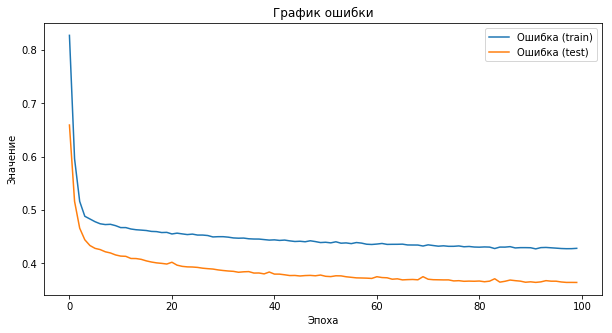

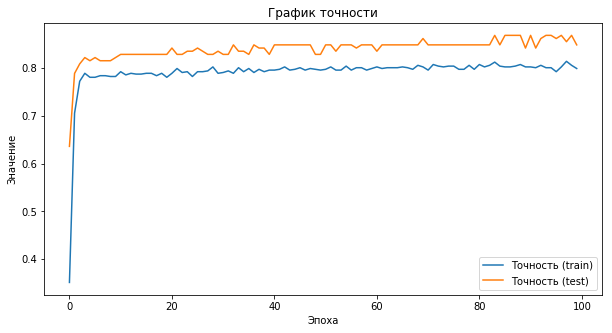

In [24]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [25]:
#улучшение сети - ранняя остановка 
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
#     Так как у нас теперь есть рання остановка мы можем увеличеть количество эпох (было 100 стало 300)
    epochs=300,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
#             На основе какого значения будет приниматься решеня об остановке
            monitor='val_categorical_accuracy',
#             Указываем направления лучшего значения (min, max, auto) лучшим является если тестовая точноть будет максимальной
            mode='max',
#             Количество эпок в резельтате которых если значение не изменилось, то произвести остановку
            patience=50,
#             "Чуствительность" метода - изменения ниже данного значения дубут считатья 0 (изменения в отслеживаемом значении нету)
            min_delta=0.01,
        )
    ]
    
)

Начинаем обучение сети
Train on 600 samples, validate on 151 samples
Epoch 1/300
600/600 [==============================] - 5s 8ms/step - loss: 0.6034 - categorical_accuracy: 0.6733 - val_loss: 0.5164 - val_categorical_accuracy: 0.7682
Epoch 2/300
600/600 [==============================] - 3s 5ms/step - loss: 0.5348 - categorical_accuracy: 0.7733 - val_loss: 0.4704 - val_categorical_accuracy: 0.8212
Epoch 3/300
600/600 [==============================] - 2s 4ms/step - loss: 0.5057 - categorical_accuracy: 0.7833 - val_loss: 0.4479 - val_categorical_accuracy: 0.8212
Epoch 4/300
600/600 [==============================] - 2s 4ms/step - loss: 0.4914 - categorical_accuracy: 0.7800 - val_loss: 0.4371 - val_categorical_accuracy: 0.8212
Epoch 5/300
600/600 [==============================] - 2s 4ms/step - loss: 0.4867 - categorical_accuracy: 0.7800 - val_loss: 0.4317 - val_categorical_accuracy: 0.8212
Epoch 6/300
600/600 [==============================] - 2s 4ms/step - loss: 0.4807 - categorical_

600/600 [==============================] - 2s 3ms/step - loss: 0.4402 - categorical_accuracy: 0.8083 - val_loss: 0.3804 - val_categorical_accuracy: 0.8278
Epoch 50/300
600/600 [==============================] - 3s 5ms/step - loss: 0.4407 - categorical_accuracy: 0.7983 - val_loss: 0.3727 - val_categorical_accuracy: 0.8344
Epoch 51/300
600/600 [==============================] - 3s 4ms/step - loss: 0.4398 - categorical_accuracy: 0.8033 - val_loss: 0.3705 - val_categorical_accuracy: 0.8411
Epoch 52/300
600/600 [==============================] - 2s 4ms/step - loss: 0.4409 - categorical_accuracy: 0.8050 - val_loss: 0.3701 - val_categorical_accuracy: 0.8411
Epoch 53/300
600/600 [==============================] - 2s 4ms/step - loss: 0.4388 - categorical_accuracy: 0.8033 - val_loss: 0.3677 - val_categorical_accuracy: 0.8411
Epoch 54/300
600/600 [==============================] - 2s 4ms/step - loss: 0.4353 - categorical_accuracy: 0.8067 - val_loss: 0.3707 - val_categorical_accuracy: 0.8411
Epoch

Epoch 98/300
600/600 [==============================] - 2s 3ms/step - loss: 0.4307 - categorical_accuracy: 0.8067 - val_loss: 0.3541 - val_categorical_accuracy: 0.8543
Epoch 99/300
600/600 [==============================] - 3s 5ms/step - loss: 0.4288 - categorical_accuracy: 0.8000 - val_loss: 0.3594 - val_categorical_accuracy: 0.8543
Epoch 100/300
600/600 [==============================] - 2s 4ms/step - loss: 0.4288 - categorical_accuracy: 0.8150 - val_loss: 0.3566 - val_categorical_accuracy: 0.8543
Epoch 101/300
600/600 [==============================] - 2s 3ms/step - loss: 0.4289 - categorical_accuracy: 0.8133 - val_loss: 0.3557 - val_categorical_accuracy: 0.8543
Epoch 102/300
600/600 [==============================] - 2s 4ms/step - loss: 0.4297 - categorical_accuracy: 0.8083 - val_loss: 0.3600 - val_categorical_accuracy: 0.8543
Epoch 103/300
600/600 [==============================] - 2s 3ms/step - loss: 0.4264 - categorical_accuracy: 0.8133 - val_loss: 0.3549 - val_categorical_accur

600/600 [==============================] - 2s 3ms/step - loss: 0.4241 - categorical_accuracy: 0.8100 - val_loss: 0.3491 - val_categorical_accuracy: 0.8808
Epoch 147/300
600/600 [==============================] - 2s 4ms/step - loss: 0.4246 - categorical_accuracy: 0.8183 - val_loss: 0.3542 - val_categorical_accuracy: 0.8543
Epoch 148/300
600/600 [==============================] - 3s 5ms/step - loss: 0.4235 - categorical_accuracy: 0.8167 - val_loss: 0.3492 - val_categorical_accuracy: 0.8675
Epoch 149/300
600/600 [==============================] - 2s 4ms/step - loss: 0.4253 - categorical_accuracy: 0.8167 - val_loss: 0.3569 - val_categorical_accuracy: 0.8543
Epoch 150/300
600/600 [==============================] - 2s 3ms/step - loss: 0.4244 - categorical_accuracy: 0.8133 - val_loss: 0.3544 - val_categorical_accuracy: 0.8543
Epoch 151/300
600/600 [==============================] - 2s 3ms/step - loss: 0.4242 - categorical_accuracy: 0.8133 - val_loss: 0.3565 - val_categorical_accuracy: 0.8543


In [26]:
model.evaluate(number_data_ready_X, number_data_ready_Y)

751/751 [==============================] - 0s 190us/step


[0.40564156225454634, 0.8268974701193138]

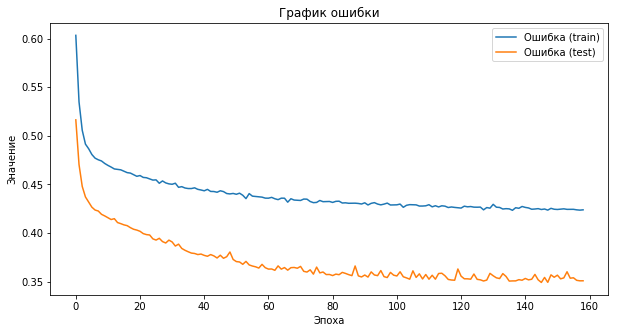

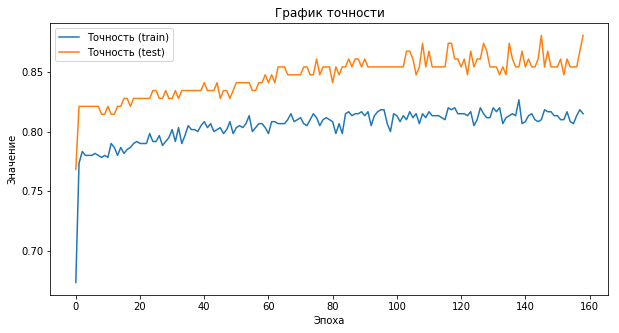

In [45]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [46]:
from pathlib import Path
from os import remove

In [49]:
# создадим функцию создания о очисти каталога контрольных точек
# указываем шаблон имени фала контрольной точки
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
#     выбираем катагол (подробнее https://docs.python.org/3.6/library/pathlib.html ) 
    checkpoints_dir = Path('./').joinpath('save_points')
    print('Текущий каталог с контрольными точками {Z}'.format(Z=checkpoints_dir.absolute()))
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print('Удаляем файл {}'.format(Z=item))
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

    

In [50]:
print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        # Добавляем сценарий ранней остановки
        # Если в течении 30 эпох точность не вырастить более чем на 1%, то произойдет остановка
        callbacks.EarlyStopping(
            monitor='val_categorical_accuracy',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
#         Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
#             Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
#             Указываем какое значение отслеживать
            monitor='val_categorical_accuracy',
#             Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
#             Говорим как часто проверять, что текущий результат лучше предидущего (в эпохах)
            period=5,
#             Указываем сторону лучших значений
            mode='max'
        )
    ]
)

Начинаем обучение сети
Текущий каталог с контрольными точками /home/dmitriy/save_points
Train on 480 samples, validate on 121 samples
Epoch 1/300
480/480 [==============================] - 6s 13ms/step - loss: 1.0303 - categorical_accuracy: 0.3063 - val_loss: 0.8209 - val_categorical_accuracy: 0.3554
Epoch 2/300
480/480 [==============================] - 3s 6ms/step - loss: 0.7691 - categorical_accuracy: 0.5292 - val_loss: 0.7510 - val_categorical_accuracy: 0.6612
Epoch 3/300
480/480 [==============================] - 2s 4ms/step - loss: 0.7251 - categorical_accuracy: 0.7625 - val_loss: 0.7184 - val_categorical_accuracy: 0.7934
Epoch 4/300
480/480 [==============================] - 2s 4ms/step - loss: 0.6866 - categorical_accuracy: 0.8688 - val_loss: 0.6720 - val_categorical_accuracy: 0.8926
Epoch 5/300
480/480 [==============================] - 2s 4ms/step - loss: 0.6487 - categorical_accuracy: 0.9083 - val_loss: 0.6407 - val_categorical_accuracy: 0.8595
Epoch 6/300
480/480 [=========

Epoch 49/300
480/480 [==============================] - 2s 4ms/step - loss: 0.5897 - categorical_accuracy: 0.9729 - val_loss: 0.5940 - val_categorical_accuracy: 0.9587
Epoch 50/300
480/480 [==============================] - 2s 4ms/step - loss: 0.5897 - categorical_accuracy: 0.9729 - val_loss: 0.5939 - val_categorical_accuracy: 0.9504
Epoch 51/300
480/480 [==============================] - 3s 6ms/step - loss: 0.5897 - categorical_accuracy: 0.9750 - val_loss: 0.5939 - val_categorical_accuracy: 0.9504
Epoch 52/300
480/480 [==============================] - 2s 4ms/step - loss: 0.5895 - categorical_accuracy: 0.9792 - val_loss: 0.5937 - val_categorical_accuracy: 0.9504
Epoch 53/300
480/480 [==============================] - 2s 4ms/step - loss: 0.5895 - categorical_accuracy: 0.9750 - val_loss: 0.5936 - val_categorical_accuracy: 0.9504
Epoch 54/300
480/480 [==============================] - 2s 4ms/step - loss: 0.5894 - categorical_accuracy: 0.9729 - val_loss: 0.5935 - val_categorical_accuracy:

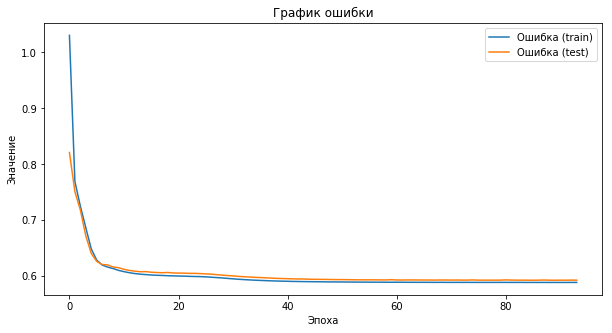

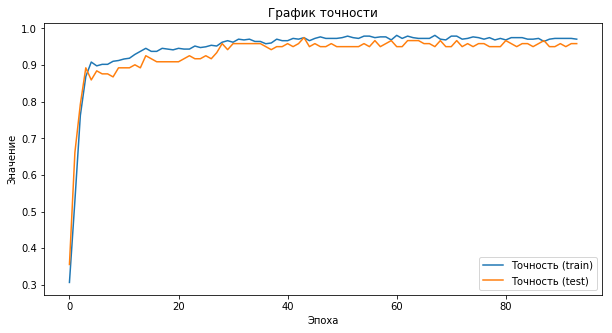

In [51]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [52]:
from keras.models import load_model

# Загружаем контрольную точку (модель)
# Обратите внимание путь до контрольной точки может отличатся
loaded_model = load_model('./save_points/nn_model_loss-0.65_val_loss-0.64_acc-0.91_val_acc-0.86.hdf5')

# Прдсказываем класс
print('Точность предсказания на тренировочных данных {Z}'.format(Z=loaded_model.evaluate(X_train, Y_train)[1]))
print('Точность предсказания на тестовых данных {Z}'.format(Z=loaded_model.evaluate(X_test, Y_test)[1]))
predict = loaded_model.predict_classes(X_test)
predict

601/601 [==============================] - 1s 847us/step
Точность предсказания на тренировочных данных 0.8901830287820686
150/150 [==============================] - 0s 191us/step
Точность предсказания на тестовых данных 0.8866666682561238


array([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0])

In [53]:
# Преобразуем классы в виде числа в их оригеналы
pipe_y.named_steps['label_encoder'].inverse_transform(predict)

/home/dmitriy/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0])

In [54]:
# Прдсказываем вероятности для классов
loaded_model.predict(X_train)

array([[0.56330264, 0.43669733],
       [0.5518525 , 0.44814742],
       [0.6891985 , 0.31080145],
       ...,
       [0.48539528, 0.5146047 ],
       [0.4713952 , 0.52860487],
       [0.5912105 , 0.40878952]], dtype=float32)